## Importing Libraries

In [1]:
!pip install lazypredict

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sn
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import pickle
import sklearn
import flask

In [11]:
print ('Versions:\n')
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('scikit-learn: ', sklearn.__version__)
print('flask: ', flask.__version__)

Versions:

numpy:  1.26.4
pandas:  2.2.2
scikit-learn:  1.4.2
flask:  3.0.3


## Loading Dataset

In [4]:
ds = pd.concat(
    [
        pd.read_csv('testing-ds.csv'),
        pd.read_csv('training-ds.csv')
    ], axis=0
)

In [5]:
ds['Churn'].value_counts()

Churn
1.00    280492
0.00    224714
Name: count, dtype: int64

In [6]:
class_counts = ds['Churn'].value_counts()

# Find the class with the smaller number of rows
min_class_count = class_counts.min()

# Create a balanced DataFrame by randomly sampling from the majority class
df = pd.concat([
    ds[ds['Churn'] == 0],
    ds[ds['Churn'] == 1].sample(min_class_count)
])

# Shuffle the rows for better randomness
df = df.sample(frac=1)

In [7]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
295588,302702.00,49.00,Male,40.00,15.00,4.00,10.00,Premium,Quarterly,699.09,3.00,0.00
391215,398330.00,48.00,Male,9.00,29.00,0.00,16.00,Standard,Quarterly,732.87,16.00,0.00
390740,397855.00,20.00,Male,12.00,19.00,0.00,13.00,Premium,Quarterly,602.80,16.00,0.00
54746,55736.00,60.00,Female,23.00,5.00,2.00,26.00,Basic,Annual,358.00,29.00,1.00
94809,97571.00,61.00,Male,9.00,23.00,3.00,25.00,Standard,Annual,957.00,14.00,1.00


In [8]:
df['Churn'].value_counts()

Churn
0.00    224714
1.00    224714
Name: count, dtype: int64

## Data Reading and Analysis

In [9]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
295588,302702.00,49.00,Male,40.00,15.00,4.00,10.00,Premium,Quarterly,699.09,3.00,0.00
391215,398330.00,48.00,Male,9.00,29.00,0.00,16.00,Standard,Quarterly,732.87,16.00,0.00
390740,397855.00,20.00,Male,12.00,19.00,0.00,13.00,Premium,Quarterly,602.80,16.00,0.00
54746,55736.00,60.00,Female,23.00,5.00,2.00,26.00,Basic,Annual,358.00,29.00,1.00
94809,97571.00,61.00,Male,9.00,23.00,3.00,25.00,Standard,Annual,957.00,14.00,1.00


In [10]:
# reindexing the dataframe df after concatenating two datasets
df.reset_index(drop=True, inplace=True)

In [11]:
df.shape

(449428, 12)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449428 entries, 0 to 449427
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         449428 non-null  float64
 1   Age                449428 non-null  float64
 2   Gender             449428 non-null  object 
 3   Tenure             449428 non-null  float64
 4   Usage Frequency    449428 non-null  float64
 5   Support Calls      449428 non-null  float64
 6   Payment Delay      449428 non-null  float64
 7   Subscription Type  449428 non-null  object 
 8   Contract Length    449428 non-null  object 
 9   Total Spend        449428 non-null  float64
 10  Last Interaction   449428 non-null  float64
 11  Churn              449428 non-null  float64
dtypes: float64(9), object(3)
memory usage: 41.1+ MB


In [13]:
# convert float values to int
for col in df.columns:
  if df[col].dtype == 'float64':
    df[col] = df[col].astype('int64')
  if df[col].dtype == 'object':
    df[col] = df[col].astype('str')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449428 entries, 0 to 449427
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   CustomerID         449428 non-null  int64 
 1   Age                449428 non-null  int64 
 2   Gender             449428 non-null  object
 3   Tenure             449428 non-null  int64 
 4   Usage Frequency    449428 non-null  int64 
 5   Support Calls      449428 non-null  int64 
 6   Payment Delay      449428 non-null  int64 
 7   Subscription Type  449428 non-null  object
 8   Contract Length    449428 non-null  object
 9   Total Spend        449428 non-null  int64 
 10  Last Interaction   449428 non-null  int64 
 11  Churn              449428 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 41.1+ MB


## Statistical Summary

In [15]:
df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,449428.00,449428.00,449428.00,449428.00,449428.00,449428.00,449428.00,449428.00,449428.00
mean,210674.71,39.44,31.39,15.77,3.65,13.19,629.79,14.49,0.50
std,139861.83,12.47,17.23,8.60,3.09,8.33,241.51,8.60,0.50
min,1.00,18.00,1.00,1.00,0.00,0.00,100.00,1.00,0.00
25%,68613.75,29.00,16.00,8.00,1.00,6.00,475.00,7.00,0.00
50%,211909.50,39.00,32.00,16.00,3.00,13.00,659.00,14.00,0.50
75%,335590.25,48.00,46.00,23.00,6.00,19.00,829.00,22.00,1.00
max,449999.00,65.00,60.00,30.00,10.00,30.00,1000.00,30.00,1.00


In [16]:
df.describe(include='object')

,Gender,Subscription Type,Contract Length
count,449428,449428,449428
unique,2,3,3
top,Male,Standard,Annual
freq,253372,151945,180318


In [17]:
# getting unique values of categorical features
for col in df.describe(include='object').columns:
  print(col,'\n',df[col].unique(),'\n')

Gender 
 ['Male' 'Female'] 

Subscription Type 
 ['Premium' 'Standard' 'Basic'] 

Contract Length 
 ['Quarterly' 'Annual' 'Monthly'] 



## Data Preprocessing

### Data Cleaning

In [18]:
# checking for any null values
df.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64



> **Indicates 1 row in the dataset contains null values**



In [19]:
# dropping row with null values
df.dropna(inplace=True)

In [20]:
# checking for duplicates values
len(df[df.duplicated()])

0



> **No dupliates values present in the dataset**



In [21]:
# removing unnecessary column
df.drop(columns='CustomerID', inplace=True)

In [22]:
# renaming the column names
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [23]:
df.head()

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,49,Male,40,15,4,10,Premium,Quarterly,699,3,0
1,48,Male,9,29,0,16,Standard,Quarterly,732,16,0
2,20,Male,12,19,0,13,Premium,Quarterly,602,16,0
3,60,Female,23,5,2,26,Basic,Annual,358,29,1
4,61,Male,9,23,3,25,Standard,Annual,957,14,1


In [24]:
df.columns

Index(['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'last_interaction', 'churn'],
      dtype='object')

## Data Visualization

### Univariate Analysis

In [25]:
df.head()

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,49,Male,40,15,4,10,Premium,Quarterly,699,3,0
1,48,Male,9,29,0,16,Standard,Quarterly,732,16,0
2,20,Male,12,19,0,13,Premium,Quarterly,602,16,0
3,60,Female,23,5,2,26,Basic,Annual,358,29,1
4,61,Male,9,23,3,25,Standard,Annual,957,14,1


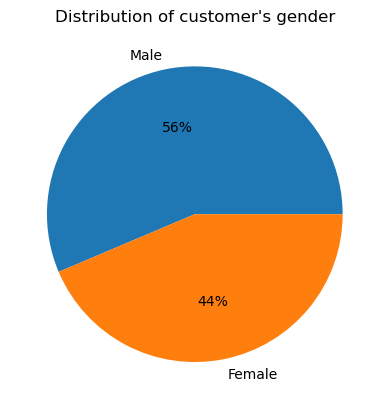

Gender Distribution

Male: 253372
Female: 196056


In [26]:
# distribution of customer's gender

gender_counts = df['gender'].value_counts()
plt.pie(gender_counts, labels=['Male', 'Female'], autopct='%.0f%%')
plt.title("Distribution of customer's gender")
plt.show()
print('Gender Distribution\n')
print(f"Male: {gender_counts[0]}")
print(f"Female: {gender_counts[1]}")



> **There are more male customers in the company**



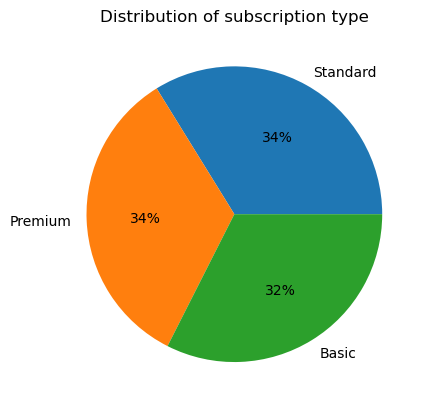

Subscription Type Distribution

Standard: 151945
Premium: 151588
Basic: 151588


In [27]:
# distribution of customer's subscription_type

subtyp_counts = df['subscription_type'].value_counts()
plt.pie(subtyp_counts, labels=['Standard', 'Premium', 'Basic'], autopct='%.0f%%')
plt.title("Distribution of subscription type")
plt.show()
print('Subscription Type Distribution\n')
print(f"Standard: {subtyp_counts[0]}")
print(f"Premium: {subtyp_counts[1]}")
print(f"Basic: {subtyp_counts[1]}")



> **Each subscription type (Standard, Premium, Basic) has a similar number of customers**



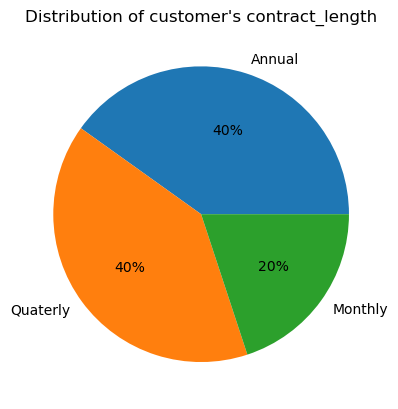

Contract Length Distribution

Annual: 180318
Quaterly: 179519
Monthly: 179519


In [28]:
# distribution of customer's contract_length
cntyp_counts = df['contract_length'].value_counts()
plt.pie(cntyp_counts, labels=['Annual', 'Quaterly', 'Monthly'], autopct='%.0f%%')
plt.title("Distribution of customer's contract_length")
plt.show()
print('Contract Length Distribution\n')
print(f"Annual: {cntyp_counts[0]}")
print(f"Quaterly: {cntyp_counts[1]}")
print(f"Monthly: {cntyp_counts[1]}")



> **Customers mostly go for either annual or quarterly contracts, with monthly contracts being the least favored option**



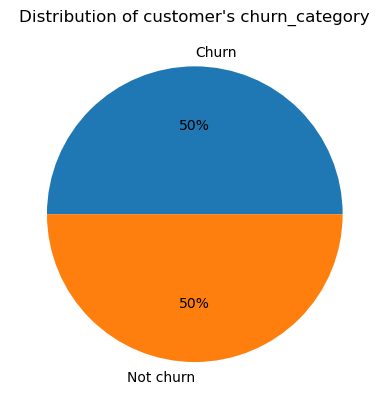

Churn Category Distribution

Churn: 224714
Not churn: 224714


In [29]:
# disttribution of customer's churn category
churn_df = df.copy()
churn_df['churn_category'] = ['Churn' if x == 1.0 else 'Not Churned' for x in df['churn']]
churn_counts = churn_df['churn_category'].value_counts()
plt.pie(churn_counts, labels=['Churn', 'Not churn'], autopct='%.0f%%')
plt.title("Distribution of customer's churn_category")
plt.show()
print('Churn Category Distribution\n')
print(f"Churn: {churn_counts[0]}")
print(f"Not churn: {churn_counts[1]}")



> **The dataset contains more entries of churned customers**



### Multivariate Analysis

#### Churn Rate by Gender

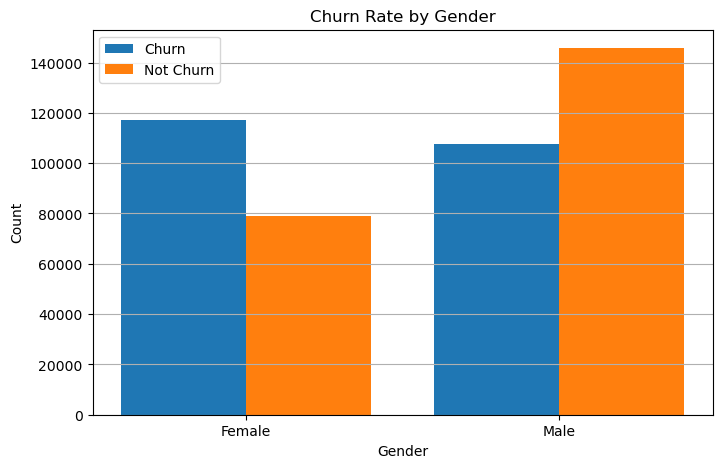

In [30]:
gender_churn = df.groupby(['gender', 'churn']).size().unstack()

gender = list(gender_churn.index)
churn_0 = list(gender_churn.loc[:, 0])
churn_1 = list(gender_churn.loc[:, 1])

barWidth = 0.40
br1 = np.arange(len(gender))
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(8, 5))
plt.bar(br1, churn_1, width=barWidth, label='Churn')
plt.bar(br2, churn_0, width=barWidth, label='Not Churn')

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Churn Rate by Gender')
plt.xticks([r + barWidth/2 for r in range(len(gender))], gender)
plt.grid(axis='y')
plt.legend()
plt.show()

> Female customers exhibit a slightly higher churn rate compared to male customers. Active male customers (non-churned) is nearly double that of female customers.

#### Churn rate by payment delay

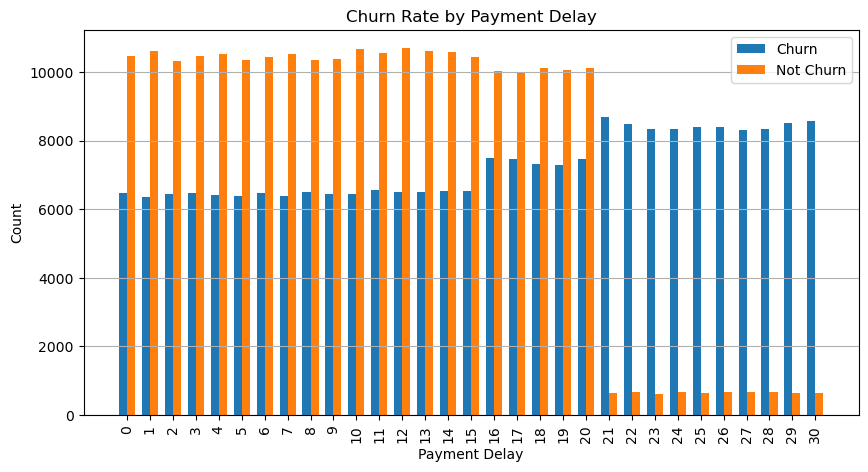

In [31]:
pay_churn = df.groupby(['payment_delay', 'churn']).size().unstack()

pay = list(pay_churn.index)
churn_0 = list(pay_churn.loc[:, 0])
churn_1 = list(pay_churn.loc[:, 1])

barWidth = 0.35
br1 = np.arange(len(pay))
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(10, 5))
plt.bar(br1, churn_1, width=barWidth, label='Churn')
plt.bar(br2, churn_0, width=barWidth, label='Not Churn')

plt.xlabel('Payment Delay')
plt.ylabel('Count')
plt.title('Churn Rate by Payment Delay')
plt.xticks([r + barWidth/2 for r in range(len(pay))], pay, rotation=90)
plt.grid(axis='y')
plt.legend()
plt.show()

> Customers who are not churned tend to have higher payment delay days as compared with churned customers till day 20, after which churned customers have payment delays just over 10 times than that of not churned customers.

#### Churn Rate by Usage Frequency

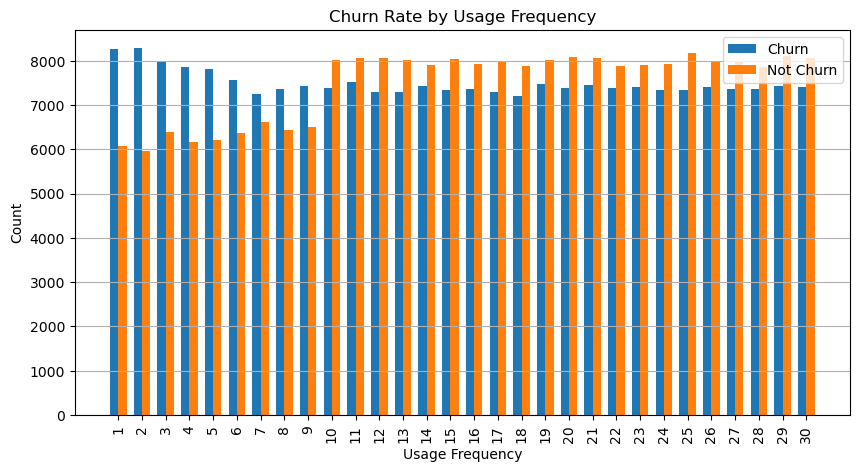

In [32]:
uf_churn = df.groupby(['usage_frequency', 'churn']).size().unstack()

uf = list(uf_churn.index)
churn_0 = list(uf_churn.loc[:, 0])
churn_1 = list(uf_churn.loc[:, 1])

barWidth = 0.35
br1 = np.arange(len(uf))
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(10, 5))
plt.bar(br1, churn_1, width=barWidth, label='Churn')
plt.bar(br2, churn_0, width=barWidth, label='Not Churn')

plt.xlabel('Usage Frequency')
plt.ylabel('Count')
plt.title('Churn Rate by Usage Frequency')
plt.xticks([r + barWidth/2 for r in range(len(uf))], uf, rotation=90)
plt.grid(axis='y')
plt.legend()
plt.show()

> Churned customer tend to use company's services significantly more than customers who are not churned.

#### Churn Rate by Tenure

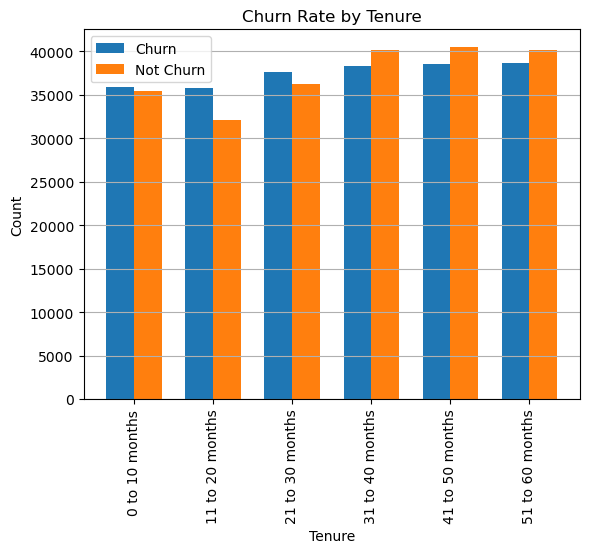

In [33]:
def categorize_age(age):
    if 0 <= age <= 10:
        return '0 to 10 months'
    elif 11 <= age <= 20:
        return '11 to 20 months'
    elif 21 <= age <= 30:
        return '21 to 30 months'
    elif 31 <= age <= 40:
        return '31 to 40 months'
    elif 41 <= age <= 50:
        return '41 to 50 months'
    elif 51 <= age <= 60:
        return '51 to 60 months'
    else:
        pass # For nan values

filtered = df.copy()
filtered['tenure_segmentation'] = df['tenure'].apply(categorize_age)
tenure_churn = filtered.groupby(['tenure_segmentation', 'churn']).size().unstack()

tenure = list(tenure_churn.index)
churn_0 = list(tenure_churn.loc[:, 0])
churn_1 = list(tenure_churn.loc[:, 1])

barWidth = 0.35
br1 = np.arange(len(tenure))
br2 = [x + barWidth for x in br1]

plt.bar(br1, churn_1, width=barWidth, label='Churn')
plt.bar(br2, churn_0, width=barWidth, label='Not Churn')

plt.xlabel('Tenure')
plt.ylabel('Count')
plt.title('Churn Rate by Tenure')
plt.xticks([r + barWidth/2 for r in range(len(tenure))], tenure, rotation=90)
plt.grid(axis='y')
plt.legend()
plt.show()

> Customers with longer tenures are less likely to churn.

#### Churn Rate by Suppport Calls

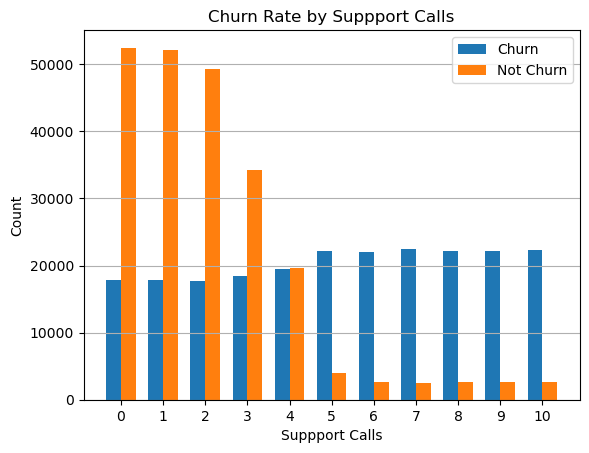

In [34]:
sc_churn = df.groupby(['support_calls', 'churn']).size().unstack()

sc = list(sc_churn.index)
churn_0 = list(sc_churn.loc[:, 0])
churn_1 = list(sc_churn.loc[:, 1])

barWidth = 0.35
br1 = np.arange(len(sc))
br2 = [x + barWidth for x in br1]

plt.bar(br1, churn_1, width=barWidth, label='Churn')
plt.bar(br2, churn_0, width=barWidth, label='Not Churn')

plt.xlabel('Suppport Calls')
plt.ylabel('Count')
plt.title('Churn Rate by Suppport Calls')
plt.xticks([r + barWidth/2 for r in range(len(sc))], sc)
plt.grid(axis='y')
plt.legend()
plt.show()

> Customers with more support calls tend to churn more.


#### Churn Rate by Subscription Type

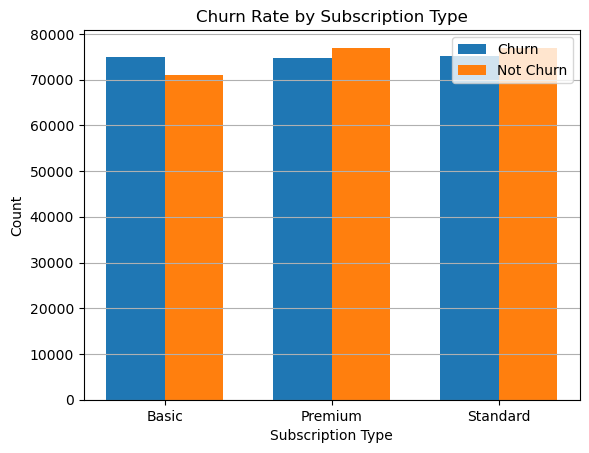

In [35]:
sub_churn = df.groupby(['subscription_type', 'churn']).size().unstack()

subtyp = list(sub_churn.index)
churn_0 = list(sub_churn.loc[:, 0])
churn_1 = list(sub_churn.loc[:, 1])

barWidth = 0.35
br1 = np.arange(len(subtyp))
br2 = [x + barWidth for x in br1]

plt.bar(br1, churn_1, width=barWidth, label='Churn')
plt.bar(br2, churn_0, width=barWidth, label='Not Churn')

plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.title('Churn Rate by Subscription Type')
plt.xticks([r + barWidth/2 for r in range(len(subtyp))], subtyp)
plt.grid(axis='y')
plt.legend()
plt.show()

> Subscription type does not influence customer churn rate.

Customers who are not churned tend to choose premium or standard subscription type slightly more than basic subscription.

#### Churn Rate by Contract Length

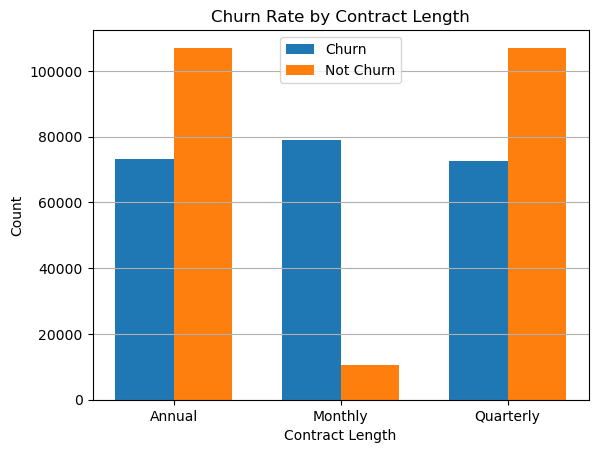

In [36]:
cl_churn = df.groupby(['contract_length', 'churn']).size().unstack()

cnt = list(cl_churn.index)
churn_0 = list(cl_churn.loc[:, 0])
churn_1 = list(cl_churn.loc[:, 1])

barWidth = 0.35
br1 = np.arange(len(cnt))
br2 = [x + barWidth for x in br1]

plt.bar(br1, churn_1, width=barWidth, label='Churn')
plt.bar(br2, churn_0, width=barWidth, label='Not Churn')

plt.xlabel('Contract Length')
plt.ylabel('Count')
plt.title('Churn Rate by Contract Length')
plt.xticks([r + barWidth/2 for r in range(len(cnt))], cnt)
plt.grid(axis='y')
plt.legend()
plt.show()

> Customers with quarterly contract lengths have the lowest churn rate, while those with monthly contract lengths exhibit the highest churn rate. Conversely, customers who do not churn overwhelmingly prefer annual and quarterly contracts over monthly contracts.

#### Churn Rate by Last Interaction

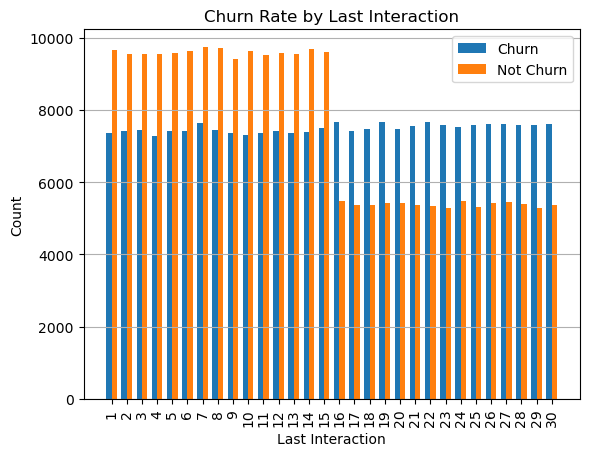

In [37]:
li_churn = df.groupby(['last_interaction', 'churn']).size().unstack()

li = list(li_churn.index)
churn_0 = list(li_churn.loc[:, 0])
churn_1 = list(li_churn.loc[:, 1])

barWidth = 0.35
br1 = np.arange(len(li))
br2 = [x + barWidth for x in br1]

plt.bar(br1, churn_1, width=barWidth, label='Churn')
plt.bar(br2, churn_0, width=barWidth, label='Not Churn')

plt.xlabel('Last Interaction')
plt.ylabel('Count')
plt.title('Churn Rate by Last Interaction')
plt.xticks([r + barWidth/2 for r in range(len(li))], li, rotation = 90)
plt.grid(axis='y')
plt.legend()
plt.show()

> Customers who interacted recently are less likely to churn

#### Churn Rate by Total Spend

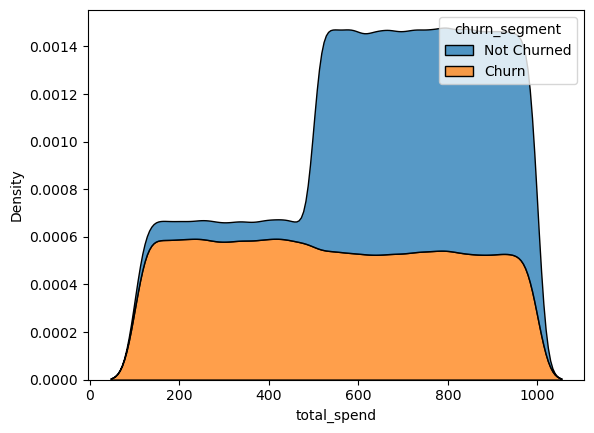

In [38]:
filtered = df.copy()
filtered['churn_segment'] = ['Churn' if x == 1.0 else 'Not Churned' for x in df['churn']]

sn.kdeplot(data=filtered, x="total_spend", hue="churn_segment", multiple="stack")
plt.show()

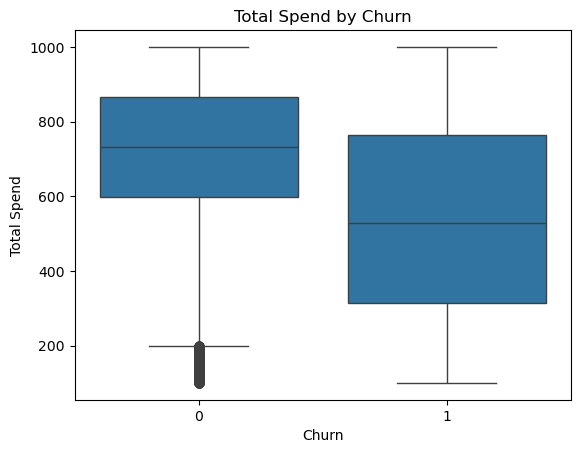

In [39]:
sn.boxplot(x='churn', y='total_spend', data=df)
plt.title('Total Spend by Churn')
plt.xlabel('Churn')
plt.ylabel('Total Spend')
plt.show()

> Customers who churn tends to spend significantly more money than those who don't.

Both churn and not churned customers share common total spending distribution / total spending behavior.

In [40]:
df.head()

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,49,Male,40,15,4,10,Premium,Quarterly,699,3,0
1,48,Male,9,29,0,16,Standard,Quarterly,732,16,0
2,20,Male,12,19,0,13,Premium,Quarterly,602,16,0
3,60,Female,23,5,2,26,Basic,Annual,358,29,1
4,61,Male,9,23,3,25,Standard,Annual,957,14,1




#### ==> adding new features for multivariate analysis



In [41]:
# Create a copy of the original DataFrame
df_analysis = df.copy()

# 1. Total Spend per Month
df_analysis['total_spend_per_month'] = df_analysis['total_spend'] / df_analysis['tenure']

# 2. Average Interaction Time (using Last Interaction as a proxy)
avg_support_call_duration = 10  # in minutes
df_analysis['avg_interaction_time'] = (df_analysis['support_calls'] * avg_support_call_duration) / df_analysis['tenure']

# 3. Tenure & Subscription Type Interaction (using pd.get_dummies and interaction terms)
df_analysis['subscription_type'] = df_analysis['subscription_type'].str.strip()
dummies = pd.get_dummies(df_analysis['subscription_type'], prefix='sub_type', dtype= int)
final_df = pd.concat([df_analysis, dummies], axis=1)
final_df['tenure_sub_basic'] = final_df['tenure'] * final_df['sub_type_Basic']
final_df['tenure_sub_premium'] = final_df['tenure'] * final_df['sub_type_Premium']
final_df['tenure_sub_standard'] = final_df['tenure'] * final_df['sub_type_Standard']
final_df['tenure_sub_basic'] = final_df['tenure_sub_basic'].astype(int)
final_df['tenure_sub_premium'] = final_df['tenure_sub_premium'].astype(int)
final_df['tenure_sub_standard'] = final_df['tenure_sub_standard'].astype(int)

In [42]:
final_df.head()

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn,total_spend_per_month,avg_interaction_time,sub_type_Basic,sub_type_Premium,sub_type_Standard,tenure_sub_basic,tenure_sub_premium,tenure_sub_standard
0,49,Male,40,15,4,10,Premium,Quarterly,699,3,0,17.48,1.00,0,1,0,0,40,0
1,48,Male,9,29,0,16,Standard,Quarterly,732,16,0,81.33,0.00,0,0,1,0,0,9
2,20,Male,12,19,0,13,Premium,Quarterly,602,16,0,50.17,0.00,0,1,0,0,12,0
3,60,Female,23,5,2,26,Basic,Annual,358,29,1,15.57,0.87,1,0,0,23,0,0
4,61,Male,9,23,3,25,Standard,Annual,957,14,1,106.33,3.33,0,0,1,0,0,9


#### Churn rate by Total spend per month

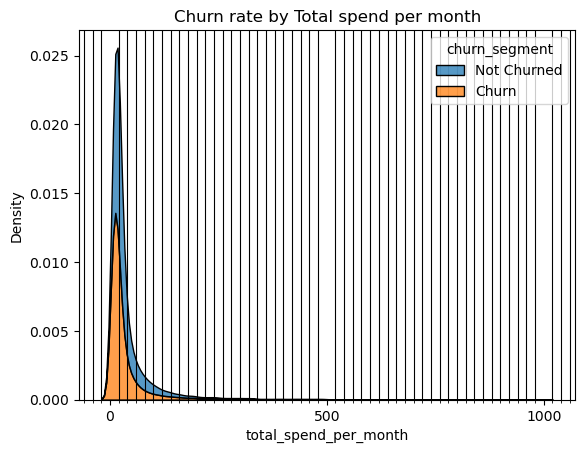

In [43]:
filtered = final_df.copy()
filtered['churn_segment'] = ['Churn' if x == 1.0 else 'Not Churned' for x in final_df['churn']]

major_locator = MultipleLocator(500)
minor_locator = MultipleLocator(20)
plt.gca().xaxis.set_major_locator(major_locator)
plt.gca().xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor', color='black')
sn.kdeplot(data=filtered, x="total_spend_per_month", hue="churn_segment", multiple="stack")
plt.title('Churn rate by Total spend per month')
plt.show()

> The overlapping areas indicate that there are customers with similar spending patterns in both groups.

The blue curve (churn) has a higher peak at lower spending levels, suggesting that customers with lower spending are more likely to churn.

The orange curve (not churned) has a higher peak at higher spending levels, suggesting that customers with higher spending are less likely to churn.

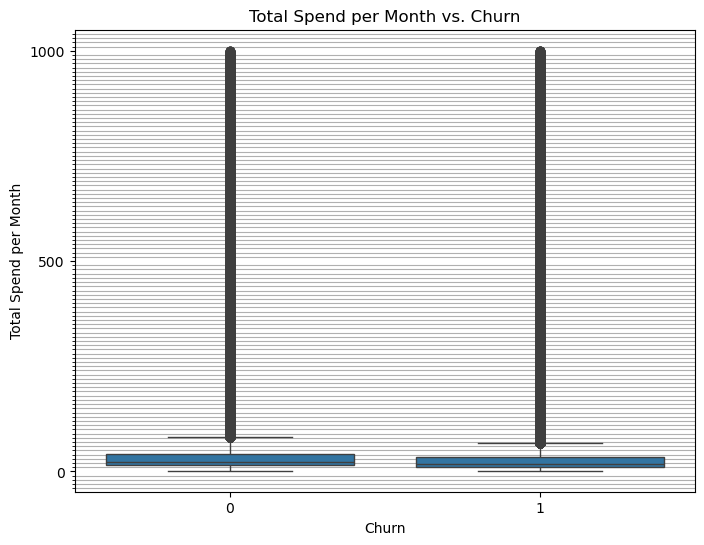

In [44]:
plt.figure(figsize=(8, 6))
sn.boxplot(data=df_analysis, x='churn', y='total_spend_per_month')
plt.title('Total Spend per Month vs. Churn')
plt.xlabel('Churn')
plt.ylabel('Total Spend per Month')
major_locator = MultipleLocator(500)
minor_locator = MultipleLocator(10)
plt.gca().yaxis.set_major_locator(major_locator)
plt.gca().yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
plt.show()

> While the median spend is similar for both groups, the presence of outliers in the churned group might suggest that some customers with very high or very low spending are more likely to churn.

#### Churn Rate by Subscription Type and Tenure Group

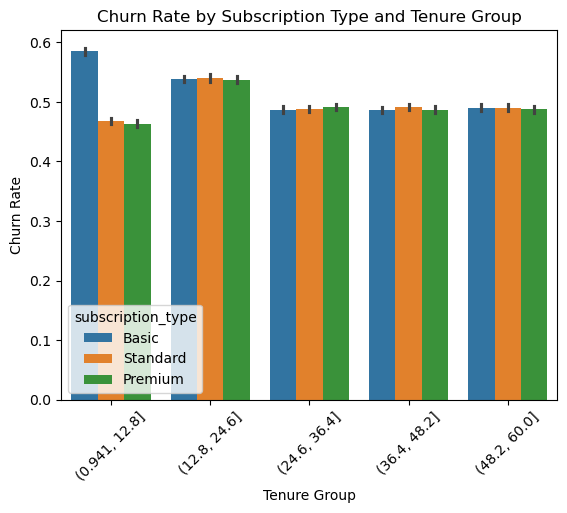

In [45]:
final_df['tenure_group'] = pd.cut(final_df['tenure'], bins=5)
sn.barplot(data=final_df, x='tenure_group', y='churn', hue='subscription_type',
hue_order=['Basic', 'Standard', 'Premium'])
plt.title('Churn Rate by Subscription Type and Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45)
plt.show()

> These observations suggest that customers with Basic subscriptions are more likely to churn in the early stages of their tenure. Retention efforts might be particularly important for this customer segment.

## Splitting Dataset & Encoding categorical data

In [46]:
X= df.drop('churn', axis=1)
y= df['churn']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

categorical_cols = ['gender', 'subscription_type', 'contract_length']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train[categorical_cols])

feature_names = ohe.get_feature_names_out(categorical_cols)

X_train_encoded = ohe.transform(X_train[categorical_cols])
X_test_encoded = ohe.transform(X_test[categorical_cols])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names, dtype=int)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=feature_names, dtype= int)

X_train = pd.concat([X_train.drop(categorical_cols, axis=1), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(categorical_cols, axis=1), X_test_encoded_df], axis=1)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((269656, 15), (179772, 15), (269656,), (179772,))

## Training models

In [49]:
model_params={
    'decisiontree':{
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion':['gini', 'entropy']
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', max_iter=100),
        'params': {
            'C':[1,10]
        }
    },
    'random_forest':{
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[1,10]
        }
    },
    'knn':{
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors':[1,10]
        }
    },
    'xgb':{
        'model': XGBClassifier(),
        'params': {
            'n_estimators':[1,10]
        }
    }
}

scores=[]
for model_name, mp in model_params.items():
    rs=GridSearchCV(mp['model'], mp['params'], cv=5)
    rs.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': rs.best_score_,
        'best_params': rs.best_params_
    })

model_performance_df= pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
model_performance_df

,model,best_score,best_params
0,decisiontree,0.88,{'criterion': 'entropy'}
1,logistic_regression,0.84,{'C': 10}
2,random_forest,0.92,{'n_estimators': 10}
3,knn,0.83,{'n_neighbors': 10}
4,xgb,0.92,{'n_estimators': 10}


## fitting dataset to the model

### Random forest classifier

In [50]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91     89641
           1       0.88      0.97      0.92     90131

    accuracy                           0.91    179772
   macro avg       0.92      0.91      0.91    179772
weighted avg       0.92      0.91      0.91    179772



In [52]:
accuracy_score(y_test, y_pred)

0.9148031951583117

> **91% accuracy**

### xgboost

In [53]:
xgb = XGBClassifier(n_estimators=10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     89641
           1       0.87      0.99      0.93     90131

    accuracy                           0.92    179772
   macro avg       0.93      0.92      0.92    179772
weighted avg       0.93      0.92      0.92    179772



In [55]:
accuracy_score(y_test, y_pred)

0.9222403933871793

> **92% accuracy**

# from above analysis, we can conclude both **Random forest** and **XGBoost Classifier** are the best for this problem

## testing the model (on XGBoost)

In [56]:
new_data = {'age': 53, 'tenure': 2, 'usage_frequency': 2, 'support_calls': 22, 'payment_delay': 2,
       'total_spend': 533, 'last_interaction': 2, 'gender_Female':0, 'gender_Male':1,
       'subscription_type_Basic':1, 'subscription_type_Premium':0,
       'subscription_type_Standard':0, 'contract_length_Annual':0,
       'contract_length_Monthly':1, 'contract_length_Quarterly':0}

# Convert the new data point to a DataFrame
new_data_df = pd.DataFrame([new_data])

# Make the prediction
prediction = xgb.predict(new_data_df)

print(prediction)

[1]


## Pickling the model

In [57]:
with open("ohe_encoder.pkl", "wb") as f:
    pickle.dump(ohe, f)

In [58]:
filename= 'pred_churn.pkl'
pickle.dump(xgb, open(filename, 'wb'))

## loading and using dumped model

In [59]:
with open("pred_churn.pkl", "rb") as f:
    model = pickle.load(f)

with open("ohe_encoder.pkl", "rb") as f:
    ohe = pickle.load(f)

user_data = {
    'age': 56,
    'gender': 'Male',
    'tenure': 26,
    'usage_frequency': 23,
    'support_calls': 0,
    'payment_delay': 0,
    'subscription_type': 'Premium',
    'contract_length': 'Annual',
    'total_spend': 2400,
    'last_interaction': 5
}

user_df = pd.DataFrame([user_data])
categorical_features = ['gender', 'subscription_type', 'contract_length']

user_encoded = ohe.transform(user_df[categorical_features])
user_df_encoded = pd.DataFrame(user_encoded, columns=ohe.get_feature_names_out(categorical_features))
user_df_encoded = user_df_encoded.astype(int)

final_df = pd.concat([user_df.drop(categorical_features, axis=1).reset_index(drop=True), user_df_encoded.reset_index(drop=True)], axis=1)

final_df = final_df.reindex(columns=model.feature_names_in_, fill_value=0)

prediction = model.predict(final_df)
print(prediction)

[1]


In [60]:
def calculate_risk_level(features):
    risk_score = 0

    # Assign weights based on feature thresholds
    if features['tenure'] < 12:  # Low tenure
        risk_score += 2
    if features['support_calls'] > 5:  # Many support calls
        risk_score += 2
    if features['payment_delay'] > 10:  # Frequent payment delays
        risk_score += 2
    if features['last_interaction'] > 30:  # Last interaction > 30 days ago
        risk_score += 1

    # Map risk_score to risk levels
    if risk_score >= 5:
        return "High"
    elif 3 <= risk_score < 5:
        return "Medium"
    else:
        return "Low"

ans= calculate_risk_level(user_data)
ans

'Low'

In [61]:
user_data['risk_level'] = calculate_risk_level(user_data)

def calculate_clv(features):
    # Example: Define average revenue and expected lifetime
    avg_monthly_revenue = features['total_spend'] / features['tenure'] if features['tenure'] > 0 else 0
    expected_lifetime = 12  # Assume 1 year as default

    # Adjust lifetime based on churn risk
    if features['risk_level'] == "High":
        expected_lifetime = 6  # Shorter lifetime for high-risk customers
    elif features['risk_level'] == "Medium":
        expected_lifetime = 12
    elif features['risk_level'] == "Low":
        expected_lifetime = 24  # Longer lifetime for low-risk customers

    # Calculate CLV
    clv = avg_monthly_revenue * expected_lifetime
    return round(clv, 2)

ans = calculate_clv(user_data)
ans

2215.38

## model performance

In [62]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(solver='liblinear', max_iter=100),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier()
}

for model_name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  report = classification_report(y_test, y_pred, output_dict=True)
  print(f"--- {model_name} ---")
  print(f"Accuracy: {report['accuracy']:.4f}")
  print(f"Precision: {report['macro avg']['precision']:.4f}")
  print(f"Recall: {report['macro avg']['recall']:.4f}")
  print(f"F1-score: {report['macro avg']['f1-score']:.4f}")
  print("-" * 20)

--- Decision Tree ---
Accuracy: 0.8748
Precision: 0.8749
Recall: 0.8748
F1-score: 0.8747
--------------------
--- Logistic Regression ---
Accuracy: 0.8441
Precision: 0.8449
Recall: 0.8441
F1-score: 0.8440
--------------------
--- Random Forest ---
Accuracy: 0.9256
Precision: 0.9338
Recall: 0.9254
F1-score: 0.9252
--------------------
--- KNN ---
Accuracy: 0.8382
Precision: 0.8407
Recall: 0.8383
F1-score: 0.8379
--------------------
--- XGBoost ---
Accuracy: 0.9248
Precision: 0.9327
Recall: 0.9246
F1-score: 0.9245
--------------------


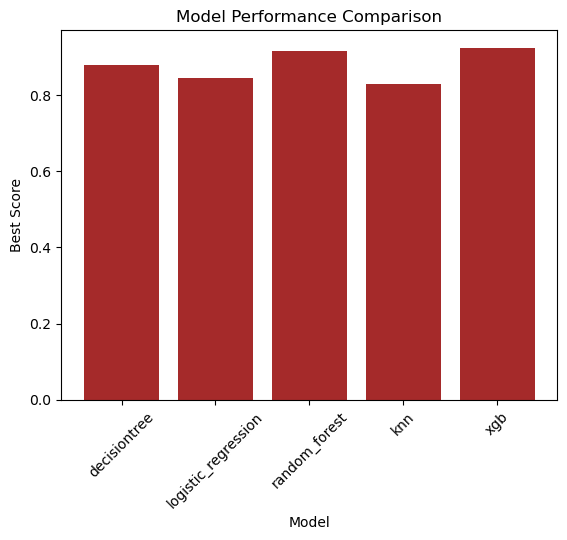

In [63]:
plt.bar(model_performance_df['model'], model_performance_df['best_score'], color='brown')
plt.xlabel("Model")
plt.ylabel("Best Score")
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.show()

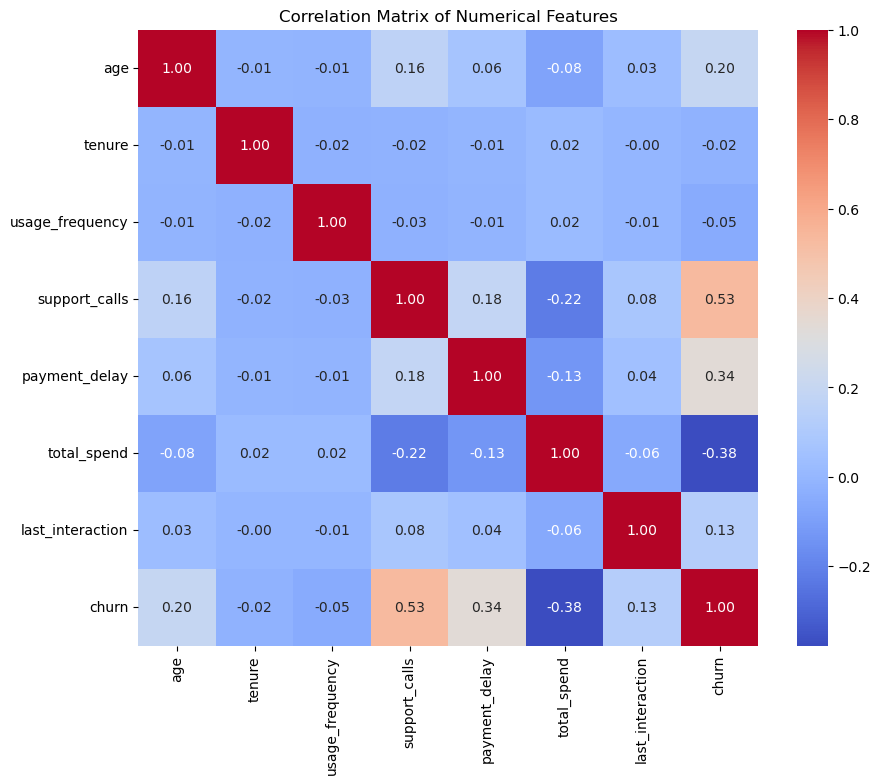

In [64]:
# Heatmap for correlation matrix
numerical_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()